In [1]:
import simpsom as sps
sps.SOMNet

simpsom.network.SOMNet

In [14]:
import numpy as np
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:

from configs.ve import cifar10_ncsnpp_continuous as configs
config = configs.get_config()

In [4]:
def build_mapping_fn(config):

  if config.training.sde == "vesde":
    def std_to_t(s):
      return (np.log(s)-np.log(config.model.sigma_min)) / (np.log(config.model.sigma_max)-np.log(config.model.sigma_min))
  else:
    def std_to_t(s):
      return (np.log(s)-np.log(config.model.sigma_min)) / (np.log(config.model.sigma_max)-np.log(config.model.sigma_min))

  return std_to_t

std_to_t = build_mapping_fn(config)

In [5]:
%%time
base_dir = "./vesde_score_norms/"
START,END,SKIP = 0, 800, 40
with open(f"{base_dir}/{config.training.sde}_scores.npz", "rb") as f:
  score_data = np.load(f, allow_pickle=True)
  score_dict = {k: score_data[k][:, START:END:SKIP] for k in score_data}

with open(f"{base_dir}/{config.training.sde}_scores_ood.npz", "rb") as f:
  ood_score_data = np.load(f, allow_pickle=True)
  ood_score_dict = {k: ood_score_data[k][:, START:END:SKIP] for k in ood_score_data}

CPU times: user 282 ms, sys: 17.6 ms, total: 300 ms
Wall time: 308 ms


In [6]:
score_dict.keys()

dict_keys(['train', 'cifar'])

(Text(0.5, 0, 'Sigmas'), Text(0, 0.5, 'Timepoints'))

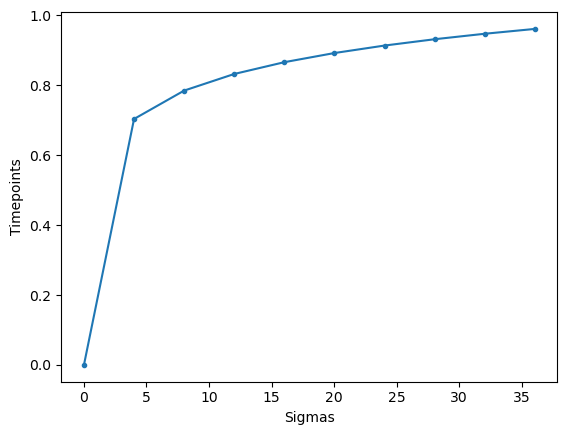

In [7]:
n_timesteps = 1000
msma_sigmas = np.linspace(config.model.sigma_min, config.model.sigma_max, n_timesteps)[
    START:END:SKIP
]
timesteps = list(map(std_to_t, msma_sigmas))
eps = 1e-5
timesteps[0] = 1e-5
plt.plot(msma_sigmas[::2], timesteps[::2], marker=".")
plt.xlabel("Sigmas"), plt.ylabel("Timepoints")

In [8]:
ood_score_dict.keys()

dict_keys(['SVHN', 'LSUN', 'LSUN_resize', 'Imagenet', 'Imagenet_resize', 'iSUN'])

In [9]:
score_dict["cifar"].shape, msma_sigmas.shape, score_dict["train"].shape

((1024, 20), (20,), (8960, 20))

In [10]:
inlier_scores = score_dict["cifar"]
train_scores = score_dict["train"]

In [11]:
df1 = pd.DataFrame(train_scores, columns=msma_sigmas)
df1["dataset"] = "Train"
df2 = pd.DataFrame(inlier_scores, columns=msma_sigmas)
df2["dataset"] = "CIFAR"

scores = [df1, df2]

for name, s in ood_score_dict.items():
  print(s.shape)
  df = pd.DataFrame(s ** 1, columns=msma_sigmas)
  df["dataset"] = name
  scores.append(df)

df = pd.concat(scores).melt(id_vars=["dataset"], var_name="sigma", value_name="score")
df

(1024, 20)
(1024, 20)
(1024, 20)
(1024, 20)
(1024, 20)
(1024, 20)


dataset     sigma      score
0        Train      0.01  23.005230
1        Train      0.01  21.567888
2        Train      0.01  20.916515
3        Train      0.01  24.826536
4        Train      0.01  23.581663
...        ...       ...        ...
322555    iSUN  38.04043   6.105167
322556    iSUN  38.04043   7.018471
322557    iSUN  38.04043   6.453895
322558    iSUN  38.04043   6.560213
322559    iSUN  38.04043   6.953295

[322560 rows x 3 columns]

<Axes: xlabel='sigma', ylabel='score'>

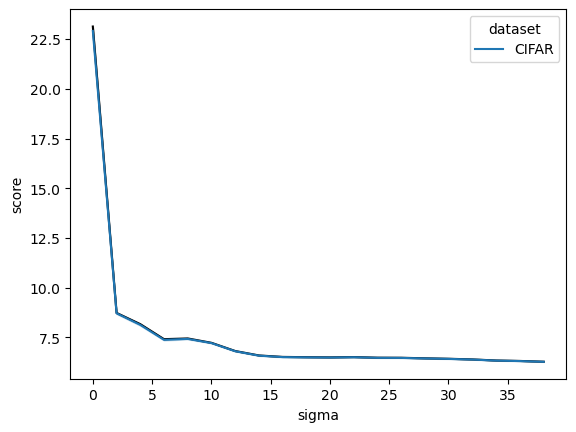

In [15]:
ax=sns.lineplot(data=df.query('dataset=="Train"'), x = "sigma", y="score", c="black", errorbar='se')
sns.lineplot(data=df.query('dataset=="CIFAR"'), x = "sigma", y="score", hue="dataset", errorbar='se', ax=ax)

<Axes: xlabel='sigma', ylabel='score'>

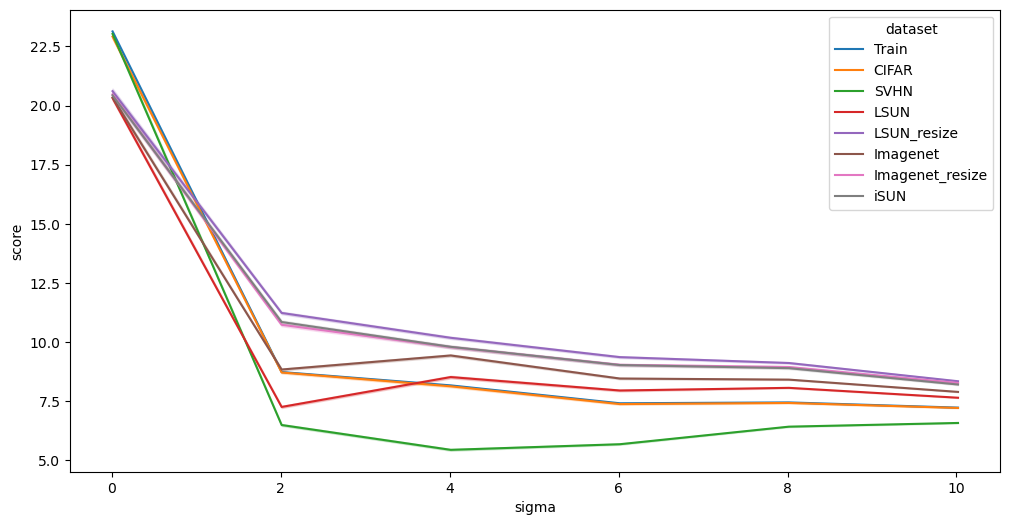

In [16]:
fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=100)
sns.lineplot(data=df.query("sigma < 10.1"), x = "sigma", y="score", hue="dataset", errorbar='se', ax=ax)

/var/folders/b2/xdjxvkmd0qj2t5gm4917xxl80000gn/T/ipykernel_87981/2001969015.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(data=df.query("sigma > 10.1"), x = "sigma", y="score", hue="dataset", ci="sd", ax=ax)


<Axes: xlabel='sigma', ylabel='score'>

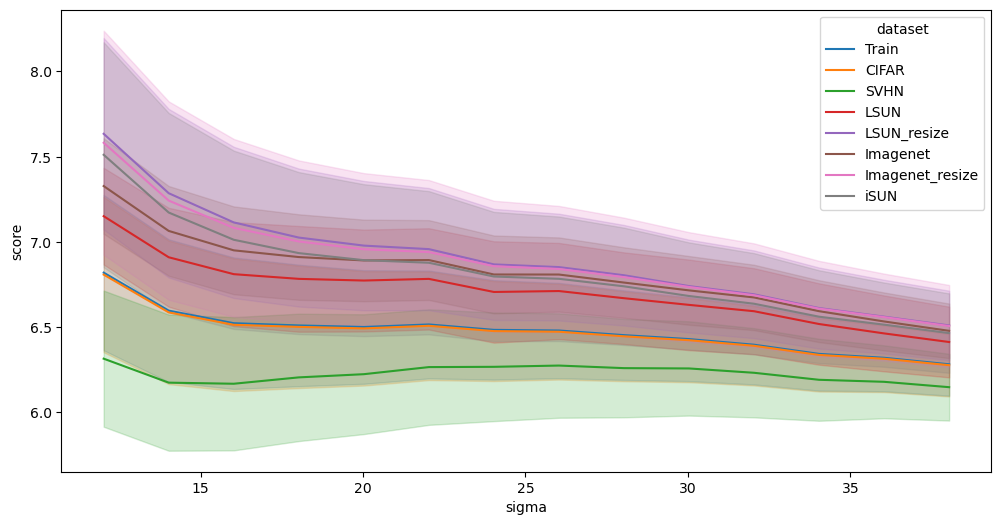

In [17]:
fig, ax = plt.subplots(1,1, figsize=(12,6), dpi=100)
sns.lineplot(data=df.query("sigma > 10.1"), x = "sigma", y="score", hue="dataset", ci="sd", ax=ax)

## Training a SOM

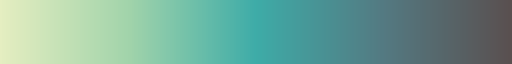

In [18]:
from pylettes import Tundra
pylette = Tundra(reverse=True).cmap
pylette

In [19]:
train_scores.shape

(8960, 20)

In [20]:
start_t = 0
delta_t = 1
end_t = -1

X_train = train_scores[:, start_t:end_t:delta_t]
X_train_with_ood = [train_scores[:, start_t:end_t:delta_t]]
X_test = [inlier_scores[:, start_t:end_t:delta_t]]
X_labels = [["CIFAR"]*len(inlier_scores)]

for name, s in ood_score_dict.items():
  X_train_with_ood.append(s[:, start_t:end_t:delta_t])
  X_test.append(s[:, start_t:end_t:delta_t])
  X_labels.append([name]*len(X_test[-1]))


X_train_with_ood = np.concatenate(X_train_with_ood, axis=0)
X_test = np.concatenate(X_test, axis=0)
X_labels = np.concatenate(X_labels)

In [21]:
mu, std = X_train.mean(axis=0), X_train.std(axis=0)

In [22]:
X_train_normalized = (X_train_with_ood - mu) / std
X_test_normalized = (X_test - mu) / std

In [23]:
X_test.shape, X_labels.shape, X_labels[:3]

((7168, 19), (7168,), array(['CIFAR', 'CIFAR', 'CIFAR'], dtype='<U15'))

In [89]:
net = sps.SOMNet(30, 30, X_train_normalized, topology='hexagonal',
                init='PCA', metric='euclidean',
                neighborhood_fun='gaussian', PBC=True,
                random_seed=32, GPU=False, CUML=False,
                output_path="./")

net.train(train_algo='batch', start_learning_rate=0.01, epochs=-1, batch_size=-1)

2024-03-16 12:17:21.547 | INFO     | simpsom.network:__init__:106 - Periodic Boundary Conditions active.
2024-03-16 12:17:21.549 | INFO     | simpsom.network:__init__:115 - Hexagonal topology.
2024-03-16 12:17:21.549 | WARNING  | simpsom.network:_set_weights:178 - Please make sure that the data have been standardized before using PCA.
2024-03-16 12:17:21.550 | INFO     | simpsom.network:_set_weights:180 - The weights will be initialized with PCA.
2024-03-16 12:17:21.569 | INFO     | simpsom.network:train:374 - The map will be trained with the batch algorithm.


2024-03-16 12:17:31.699 | INFO     | simpsom.network:get_nodes_difference:579 - Weights difference among neighboring nodes calculated.


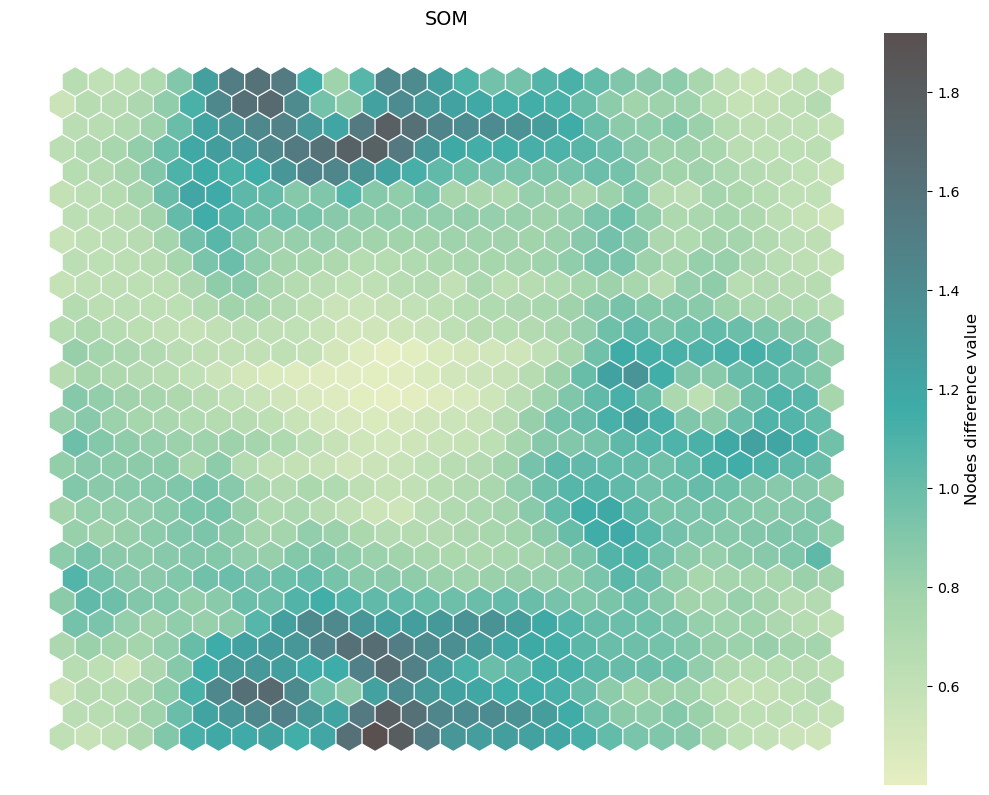

2024-03-16 12:17:32.132 | INFO     | simpsom.network:plot_map_by_difference:751 - Node difference map will be saved to:
././som_difference.png


In [90]:
net.plot_map_by_difference(show=True, print_out=True, cmap=pylette, figsize=(10,12))

In [91]:
projected_data = net.project_onto_map(X_test_normalized)
projected_data.shape

2024-03-16 12:17:32.159 | INFO     | simpsom.network:project_onto_map:604 - Projected coordinates will be saved to:
././som_projected.npy


(7168, 2)

In [92]:
labels = np.unique(X_labels)
labels

array(['CIFAR', 'Imagenet', 'Imagenet_resize', 'LSUN', 'LSUN_resize',
       'SVHN', 'iSUN'], dtype='<U15')

In [93]:
projected_data[X_labels=="CIFAR"].shape

(1024, 2)

[20.5 15.   9.5 ... 28.5 16.5 19. ]
[18.  26.  20.  ...  3.   8.  18.5]
[ 8.   8.  11.  ...  8.5 10.   5.5]
[25.  29.  24.  ... 29.  24.5 18.5]
[12.   7.5  4.  ... 11.5 11.5 12.5]
[23.5 19.5 22.5 ... 25.5 24.5  1. ]
[20.5  8.   7.5 ...  9.5 10.  10. ]


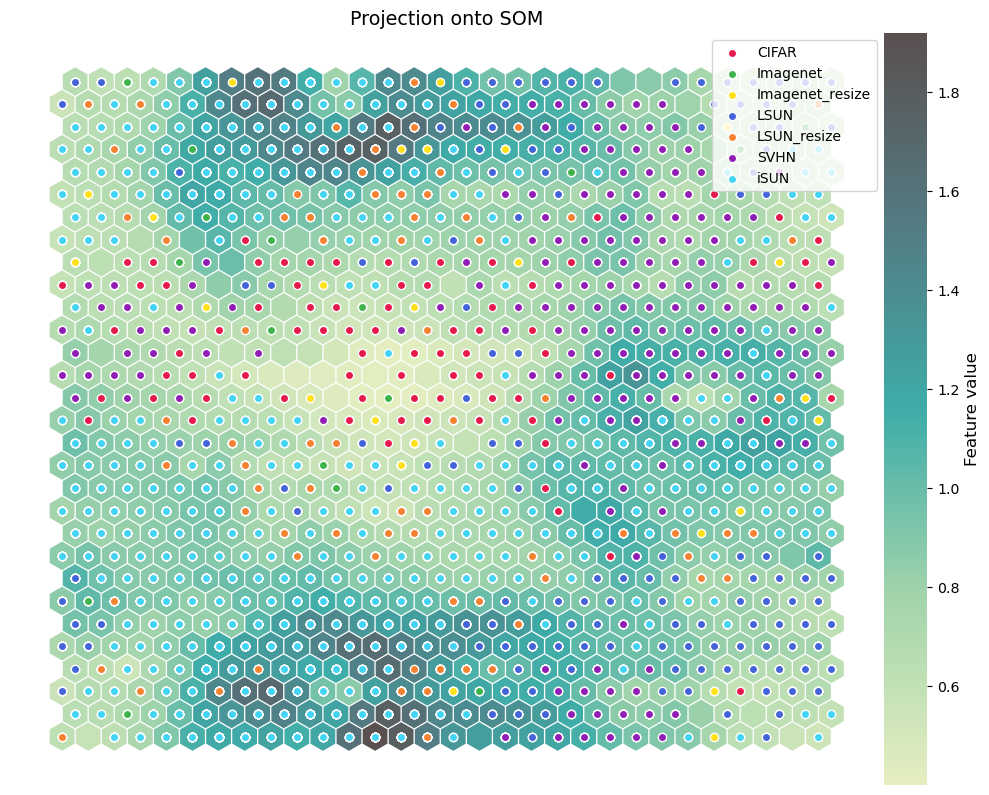

In [94]:
from simpsom.plots import scatter_on_map

fig, ax = scatter_on_map([projected_data[X_labels==l] for l in labels],
               [[node.pos[0], node.pos[1]] for node in net.nodes_list],
               net.polygons, color_val=[n.difference for n in net.nodes_list],
               show=False, print_out=True, cmap=pylette,  figsize=(10,10))
ax.legend(labels=[l for l in labels])

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
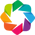

In [95]:
import holoviews as hv
import hvplot.pandas
import warnings

warnings.filterwarnings("ignore")
# from bokeh.io import output_notebook, push_notebook, show
# output_notebook()
from bokeh.plotting import show

hv.extension("bokeh")

In [129]:
df = pd.DataFrame(
    projected_data + np.random.normal(size=projected_data.shape, scale=0.03),
    columns=["x", "y"],
)
df["labels"] = X_labels
scatterplot = df.hvplot.scatter(x="x",y="y", c='labels', s=20, alpha=0.6)
p = df.hvplot.hexbin(gridsize=(net.width, net.height - 1), min_count=0, cmap="Gray")
p = p.opts(cnorm="eq_hist")

In [130]:
(p*scatterplot).opts(width=800, height=500)

:Overlay
   .HexTiles.I :HexTiles   [x,y]
   .Scatter.I  :Scatter   [x]   (y,labels)

In [97]:
# %pip install jupyter_bokeh bokeh datashader

In [98]:
from holoviews.operation.datashader import datashade, rasterize

ds = hv.Dataset(df, vdims=['labels'])

In [99]:
# projected_data

In [100]:
df = pd.DataFrame(projected_data, columns=['x','y'])
df['labels'] = X_labels
df = df.groupby(by=['labels'])
for n,d in df: print(d)

         x          y labels
0     20.5  19.918585  CIFAR
1     15.0  15.588457  CIFAR
2      9.5  16.454483  CIFAR
3      2.5  11.258330  CIFAR
4      3.5  16.454483  CIFAR
...    ...        ...    ...
1019  18.5  14.722432  CIFAR
1020   3.5  18.186533  CIFAR
1021  28.5  16.454483  CIFAR
1022  16.5  11.258330  CIFAR
1023  19.0  19.052559  CIFAR

[1024 rows x 3 columns]
         x         y    labels
4096  18.0  5.196152  Imagenet
4097  26.0  3.464102  Imagenet
4098  20.0  5.196152  Imagenet
4099  12.5  9.526279  Imagenet
4100   2.0  1.732051  Imagenet
...    ...       ...       ...
5115  10.5  7.794229  Imagenet
5116  26.0  3.464102  Imagenet
5117   3.0  3.464102  Imagenet
5118   8.0  8.660254  Imagenet
5119  18.5  7.794229  Imagenet

[1024 rows x 3 columns]
         x          y           labels
5120   8.0   3.464102  Imagenet_resize
5121   8.0   3.464102  Imagenet_resize
5122  11.0   3.464102  Imagenet_resize
5123  12.5   4.330127  Imagenet_resize
5124  17.0   5.196152  Imagenet_res

In [113]:
# df.agg(pd.Series.mode)

In [102]:
df = pd.DataFrame(projected_data + np.random.normal(size=projected_data.shape, scale=0.3), columns=['x','y'])
df['labels'] = X_labels
# df = df.groupby(by=['x','y']).agg(pd.Series.mode(x)[0]).reset_index()
# df

<Axes: xlabel='x', ylabel='y'>

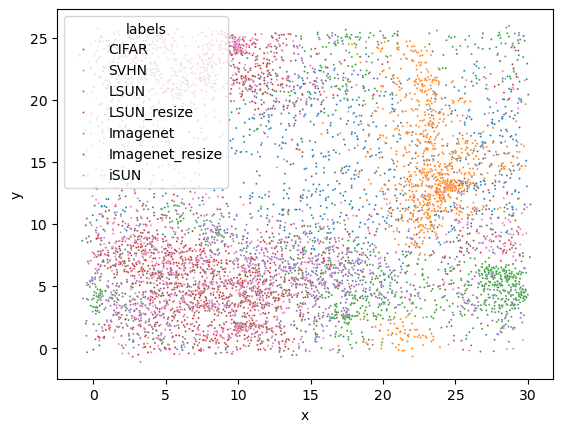

In [103]:
sns.scatterplot(data=df, x="x",y="y", hue='labels', s=2)

In [105]:
ds = hv.Dataset(df, vdims=['labels'])
hexplot = hv.HexTiles(ds, kdims=['x','y'], vdims=['labels']).opts(
    gridsize=(net.width,net.height-1),
    min_count=0,
    tools=['hover'],
    colorbar=True,

    cmap="Gray_r"
)
points = hv.Points(ds)

In [112]:
scatterplot = points.opts(color='labels', cmap="Set2", size=5, alpha=0.4, show_legend=False)
(hexplot * scatterplot).opts(height=600,width=700)

:Overlay
   .HexTiles.I :HexTiles   [x,y]   (labels)
   .Points.I   :Points   [x,y]   (labels)

In [56]:
points = hv.Points(ds)
datashade(points).relabel("Rasterized Points").opts( width=550)

:DynamicMap   []
   :RGB   [x,y]   (R,G,B,A)

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
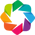

AttributeError: 'dim' object has no attribute 'ops'

In [ ]:
hv.extension('bokeh')
hexplot = hv.HexTiles(ds, kdims=['x','y'], vdims=['labels']).opts(
    gridsize=(net.width,net.height-1),
    min_count=0,
    tools=['hover'],
    colorbar=True,
    height=400,
    width=800,
    cmap="tab20",
    # cmap=hv.dim('labels')
)
hexplot.opts(color=hv.dim('labels').max())

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
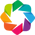

TypeError: argument of type 'LinearSegmentedColormap' is not iterable

In [ ]:
# from bokeh.io import output_notebook
hv.extension('bokeh')

# output_notebook()
df.hvplot.hexbin(gridsize=(net.width,net.height-1), min_count=0, cmap=pylette,)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:

hvplot.save(p, '/content/test.html')

/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-packages/holoviews/core/util.py:1585: PanelDeprecationWarning: 'param_value_if_widget' is deprecated and will be removed in version 1.4, use 'transform_reference' instead.
  value = param_value_if_widget(value)
/usr/local/lib/python3.10/dist-p

In [ ]:
# mean_bmus = [net.find_bmu_ix(X_test_normalized[X_labels==l].mean(axis=0, keepdims=True))
#              for l in labels]
# net.plot_projected_points([net.nodes_list[b].pos for b in mean_bmus], project=False,
#                            color_val=[n.difference for n in net.nodes_list],
#                            cmap=pylette
#                            )


In [ ]:

# for mb in mean_bmus:
#     net.plot_projected_points([net.nodes_list[mb[0]].pos],
#         project=False)
#     plt.show()

#     plt.imshow(net.nodes_list[mb[0]].weights.reshape(1, 25),
#         cmap=pylette)
#     plt.axis('off')
#     plt.show()